<a href="https://colab.research.google.com/github/gisynw/ssj-376/blob/main/docs/Labs/Practice01/Practice01_DynamicSQL.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" style="height: 30px;"/>
</a>

<a href="./Labs/Practice01/Practice01_DynamicSQL.ipynb" target="_blank"> 
  <img src="https://img.icons8.com/?size=100&id=108635&format=png&color=000000" alt="Download" style="height: 40px;"/>
 </a>

<center>
    <h2 style="color: #526cfe ; font-family: Arial, sans-serif; font-size: 32px; padding: 10px;">
        Practice 01: Dynamic SQL: Function
    </h2>
</center>

In [2]:
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy import inspect
from sqlalchemy import text
import os
import geopandas as gpd

In [3]:
host = 'localhost'
database = 'spatialdata'
user = 'postgres'
port = '5432'
password = os.getenv('SQL_PASSWORD')

In [4]:
connection_string = f"postgresql://{user}:{password}@{host}:{port}/{database}"

engine = create_engine(connection_string)
insp = inspect(engine)
insp.get_table_names()

['spatial_ref_sys', 'nyc_census_blocks_2000', 'nyc_subway_stations']

C:\Users\Administrator\AppData\Local\Temp\ipykernel_112572\437849349.py:67: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


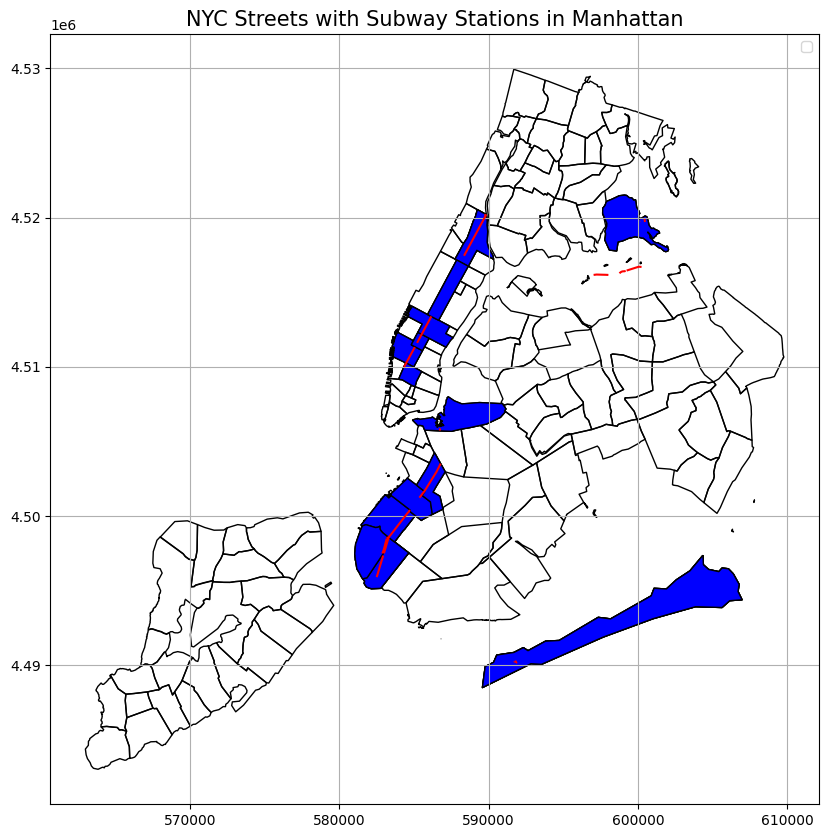

In [18]:
function_sql = """
CREATE OR REPLACE FUNCTION dynamic_subway_filter(
    schema_name TEXT,   -- Schema name
    table_name TEXT,    -- Table name

	schema_name02 TEXT,
	table_name02 TEXT, 
	
    column_name TEXT, -- Column name to filter
    streetName TEXT -- Value to filter by
)
RETURNS TABLE (
    name character varying(64),
	geom geometry(MultiPolygon,26918))
	
AS 
$$
DECLARE
    sql_query TEXT;  -- Stores the dynamic SQL query
BEGIN
    -- Construct the dynamic SQL statement
    sql_query := format(
        'SELECT neighborhood.name, neighborhood.geom
        FROM %I.%I AS street
        JOIN %I.%I AS neighborhood
        ON ST_Intersects(street.geom, neighborhood.geom)
        WHERE street.%I = %L', 
		
        schema_name, table_name,schema_name02,table_name02, column_name, streetName
    );

    -- Execute the dynamic query and return results
    RETURN QUERY EXECUTE sql_query;
END;
$$
LANGUAGE plpgsql;
"""

with engine.connect() as conn:
    conn.execute(text(function_sql))
    conn.commit()

sql_text = """select * from dynamic_subway_filter('ch05','streets', 'ch05', 'neighborhoods', 'name', '7th Ave')
"""

outcome_nbh = gpd.read_postgis(sql_text, con=engine)

## get neighborhoods
nbh_text = text(""" SELECT * FROM ch05.neighborhoods""")
all_nbh = gpd.read_postgis(nbh_text, con = engine)

## get outcome subway
subway_text = text(""" SELECT name, geom 
                      FROM ch05.streets
                      where name = '7th Ave' """)
outcome_street = gpd.read_postgis(subway_text, con = engine)


fig, ax = plt.subplots(figsize=(12, 10))

all_nbh.plot(ax=ax,facecolor = 'none',)
outcome_street.plot(ax=ax, facecolor = 'none',edgecolor='red')
outcome_nbh.plot(ax=ax, color = 'BLUE',edgecolor='black')


plt.title('NYC Streets with Subway Stations in Manhattan', fontsize=15)
plt.legend()
plt.grid(True)

In [14]:
outcome_street

,name,geom
0,8th Ave,"MULTILINESTRING ((586868.896 4505728.274, 5868..."
1,8th Ave,"MULTILINESTRING ((587881.695 4517139.039, 5879..."
2,8th Ave,"MULTILINESTRING ((591470.025 4490336.594, 5914..."
3,8th Ave,"MULTILINESTRING ((596967.23 4516070.677, 59707..."
4,8th Ave,"MULTILINESTRING ((597125.349 4516097.855, 5972..."
5,8th Ave,"MULTILINESTRING ((599180.275 4516326.301, 5992..."
6,8th Ave,"MULTILINESTRING ((599290.59 4516362.089, 59946..."
7,8th Ave,"MULTILINESTRING ((568445.16 4497212.582, 56840..."
8,8th Ave,"MULTILINESTRING ((584800.309 4500115.151, 5847..."
9,8th Ave,"MULTILINESTRING ((583967.994 4510028.476, 5840..."
